In [34]:
%pip install imbalanced-learn

Note: you may need to restart the kernel to use updated packages.


Import python package

In [35]:
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import shap

Load two dataset (read CSV file)

In [36]:
maternal = pd.read_csv('maternal_health_risk.csv') 
pree = pd.read_csv('preeclampsia.csv') 

Feature Process


In [37]:
maternal['domain'] = 0
pree['domain'] = 1
maternal.rename(columns={'Age': 'age', 'SystolicBP': 'sysbp', 'DiastolicBP': 'diabp'}, inplace=True)
combined = pd.concat([maternal, pree], axis=0, ignore_index=True)

combined['target'] = np.where(combined['RiskLevel'] == 'high risk', 1, 0)
combined['target'] = combined['target'].fillna(combined['htn'].fillna(0))

features = ['age', 'sysbp', 'diabp', 'BS', 'BodyTemp', 'HeartRate', 'bmi', 'plgf:sflt', 'SEng']
X = combined[features].copy()
imputer = SimpleImputer(strategy='median')
X = pd.DataFrame(imputer.fit_transform(X), columns=features)
y = combined['target'].values
domains = combined['domain'].values

Generate synthetic data with SMOTE

In [38]:
smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Balance classes (1:1 ratio)
X_synthetic_balanced, y_synthetic_balanced = smote.fit_resample(X, y)

Generate additional synthetic data to increase dataset size and target specific proportions

In [39]:
n_original = len(X)

Calculate original class counts

In [40]:
unique_classes, original_class_counts = np.unique(y, return_counts=True)
original_class_0_count = original_class_counts[0] if 0 in unique_classes else 0
original_class_1_count = original_class_counts[1] if 1 in unique_classes else 0

Define the target number of samples for each class after augmentation
Ensure target for class 0 is at least its original count

In [41]:
target_class_0 = max(int(n_original * 0.8), original_class_0_count)
target_class_1 = max(int(n_original * 0.2), original_class_1_count)

smote_additional = SMOTE(sampling_strategy={0: target_class_0, 1: target_class_1}, random_state=42)
X_augmented, y_augmented = smote_additional.fit_resample(X, y)


Combine original and synthetic data (using X_augmented which includes original and potentially new samples)

In [42]:
X_combined = pd.DataFrame(X_augmented, columns=features)
y_combined = y_augmented

Re-create domain labels for the combined data, assuming augmented data from the preeclampsia domain
This is a simplification; a more sophisticated approach might be needed for domain labels

In [43]:
domains_combined = np.concatenate([domains, np.ones(len(X_augmented) - len(X))])

Scale features

In [44]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X_combined)

Graph construction

In [45]:
G = nx.Graph()
for i in range(len(X_scaled)):
    G.add_node(i, features=X_scaled[i])

dist_matrix = euclidean_distances(X_scaled)
threshold = 0.3  # Consistent with original
for i in range(len(X_scaled)):
    for j in range(i + 1, len(X_scaled)):
        if dist_matrix[i][j] < threshold:
            G.add_edge(i, j, weight=1 - dist_matrix[i][j])

adj = nx.to_numpy_array(G)
adj_tensor = torch.tensor(adj, dtype=torch.float)
node_feats = torch.tensor(X_scaled, dtype=torch.float)
labels = torch.tensor(y_combined, dtype=torch.float).unsqueeze(1)
domains = torch.tensor(domains_combined, dtype=torch.float).unsqueeze(1)

5-fold CV

In [46]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Since data is augmented, we need to split the augmented data for CV
Ensure we have at least 5 samples in each class for StratifiedKFold

In [47]:
if len(np.unique(y_combined)) < 2 or np.min(np.bincount(y_combined)) < 5:
    print("Warning: Not enough samples in each class for stratified cross-validation. Using simple train/test split.")
    train_idx_all, test_idx_all = train_test_split(np.arange(len(X_combined)), test_size=0.2, random_state=42, stratify=y_combined)
else:
    train_idx_all, test_idx_all = next(cv.split(node_feats, labels.numpy().ravel()))

GCN with Reconstruction Layer

In [48]:
class UpdatedGCN(nn.Module):
    def __init__(self, in_features, hidden=64, embed_size=32, dropout_rate=0.5):
        super().__init__()
        self.gcn1 = nn.Linear(in_features, hidden)
        self.gcn2 = nn.Linear(hidden, embed_size)
        self.recon_layer = nn.Linear(embed_size, in_features)
        self.domain_classifier = nn.Linear(embed_size, 1)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, X, adj):
        adj_norm = adj + torch.eye(adj.size(0))
        degree = torch.sum(adj_norm, dim=1).clamp(min=1)
        adj_norm = adj_norm / degree.unsqueeze(1)
        emb = F.relu(self.gcn1(adj_norm @ X))
        emb = self.dropout(emb)
        emb = F.relu(self.gcn2(adj_norm @ emb))
        recon = self.recon_layer(emb)
        return emb, recon

    def domain_forward(self, emb):
        return torch.sigmoid(self.domain_classifier(emb))

Train GCN with best hyperparameters

In [49]:
gnn_model = UpdatedGCN(in_features=node_feats.shape[1], hidden=64, embed_size=32, dropout_rate=0.5)
optimizer = Adam(gnn_model.parameters(), lr=0.01)
recon_criterion = nn.MSELoss()
domain_criterion = nn.BCELoss()
best_loss = float('inf')
patience = 10
counter = 0

Federated Simulation
Update client indices to use the combined data

In [50]:
maternal_idx_combined = np.where(domains_combined == 0)[0]
pree_idx_combined = np.where(domains_combined == 1)[0]
clients_combined = [maternal_idx_combined, pree_idx_combined]

Create local models for the updated number of clients

In [51]:
local_models = [UpdatedGCN(in_features=node_feats.shape[1], hidden=64, embed_size=32, dropout_rate=0.5) for _ in clients_combined]

for epoch in range(100):
    total_loss = 0
    for i, client_idx in enumerate(clients_combined): # Use clients_combined
        local_model = local_models[i]
        local_model.train()
        optimizer.zero_grad()
        # Ensure adj_tensor indexing is correct for client data if needed,
        # but using full adj with node indexing might be simpler depending on GCN impl
        # Assuming GCN can handle indexing directly on full adj and node features
        emb, recon = local_model(node_feats[client_idx], adj_tensor[client_idx][:, client_idx])
        recon_loss = recon_criterion(recon, node_feats[client_idx])
        domain_pred = local_model.domain_forward(emb)
        domain_loss = domain_criterion(domain_pred, domains[client_idx])
        loss = recon_loss + 0.5 * domain_loss
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    with torch.no_grad():
        # Use the full test set from the combined data
        val_emb, val_recon = gnn_model(node_feats[test_idx_all], adj_tensor[test_idx_all][:, test_idx_all])
        val_loss = recon_criterion(val_recon, node_feats[test_idx_all])
    if val_loss < best_loss:
        best_loss = val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            break
    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Val Loss {val_loss:.4f}")

Epoch 0: Val Loss 0.3127
Epoch 10: Val Loss 0.3126


Get GCN embeddings

In [52]:
gnn_model.eval()
with torch.no_grad():
    embeddings, _ = gnn_model(node_feats, adj_tensor)
    embeddings = embeddings.numpy()

Train XGBoost with best hyperparameters

In [53]:
xgb_model = XGBClassifier(max_depth=5, n_estimators=100, scale_pos_weight=1, random_state=42)  # Adjusted for balanced data
xgb_model.fit(embeddings[train_idx_all], labels[train_idx_all].numpy().ravel())

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


Evaluation

In [54]:
test_preds = xgb_model.predict(embeddings[test_idx_all])
acc = accuracy_score(labels[test_idx_all].numpy(), test_preds)
auc = roc_auc_score(labels[test_idx_all].numpy(), xgb_model.predict_proba(embeddings[test_idx_all])[:, 1])
print(f"GCN + XGBoost with Synthetic Data Accuracy: {acc:.4f}, AUC: {auc:.4f}")
print(classification_report(labels[test_idx_all].numpy(), test_preds))

GCN + XGBoost with Synthetic Data Accuracy: 0.9544, AUC: 0.9802
              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       228
         1.0       0.87      0.91      0.89        57

    accuracy                           0.95       285
   macro avg       0.92      0.94      0.93       285
weighted avg       0.96      0.95      0.95       285



Visualizations
Use a consistent subset size for background and explained data for SHAP if needed
For TreeExplainer, background is not strictly required but can help with performance

In [55]:
explainer = shap.TreeExplainer(xgb_model)

 Pass embeddings_test as a numpy array to explainer.shap_values

In [56]:
shap_values = explainer.shap_values(embeddings[test_idx_all])

Assuming binary classification and shap_values is a list with two elements
For binary classification, shap_values[1] usually corresponds to the positive class

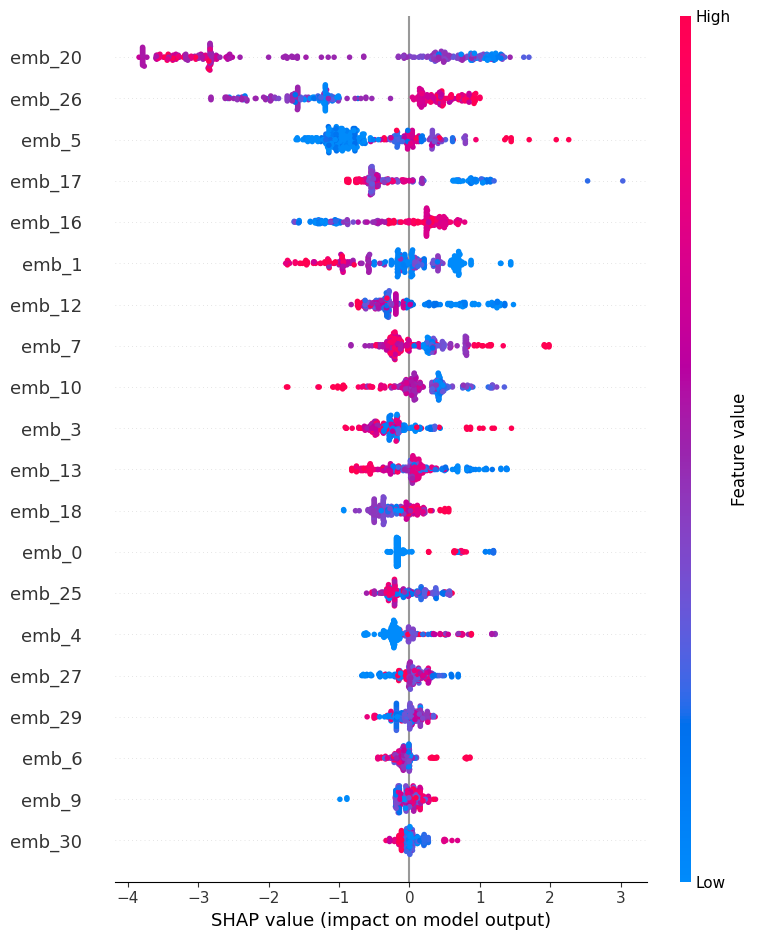

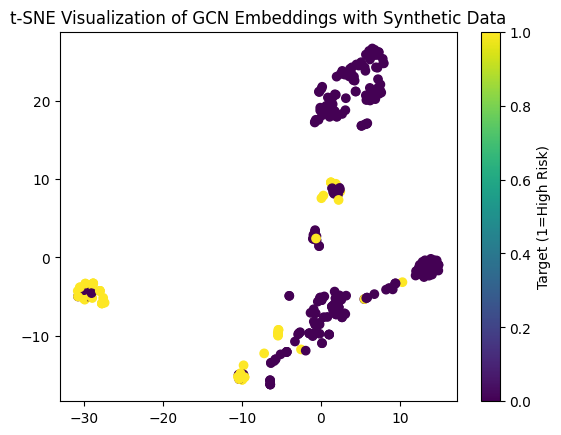

In [57]:
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap.summary_plot(shap_values[1], embeddings[test_idx_all], feature_names=[f'emb_{i}' for i in range(embeddings.shape[1])])
else:
     shap.summary_plot(shap_values, embeddings[test_idx_all], feature_names=[f'emb_{i}' for i in range(embeddings.shape[1])])

tsne = TSNE(n_components=2, random_state=42)
embed_2d = tsne.fit_transform(embeddings[test_idx_all])
plt.scatter(embed_2d[:, 0], embed_2d[:, 1], c=labels[test_idx_all].numpy(), cmap='viridis')
plt.colorbar(label='Target (1=High Risk)')
plt.title('t-SNE Visualization of GCN Embeddings with Synthetic Data')
plt.show()